In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
import numpy as np
import pandas as pd
print(np.__version__)
print(pd.__version__)

1.26.4
2.2.3


In [4]:
!python --version

Python 3.10.15


In [5]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['bairshil' 'bayrtai' 'holbogd' 'orchuul' 'seruuleg' 'temdeglel' 'tsag'
 'tsagAgaar' 'wikipedia']


In [7]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=48000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 9197 files belonging to 9 classes.
Using 7358 files for training.
Using 1839 files for validation.

label names: ['bairshil' 'bayrtai' 'holbogd' 'orchuul' 'seruuleg' 'temdeglel' 'tsag'
 'tsagAgaar' 'wikipedia']


In [8]:
train_ds.element_spec

(TensorSpec(shape=(None, 48000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [9]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [10]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [11]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 48000)
(64,)


Let's plot a few audio waveforms:

In [12]:
label_names[[0,1,2,3,4,5,6,7,8]]

array(['bairshil', 'bayrtai', 'holbogd', 'orchuul', 'seruuleg',
       'temdeglel', 'tsag', 'tsagAgaar', 'wikipedia'], dtype='<U9')

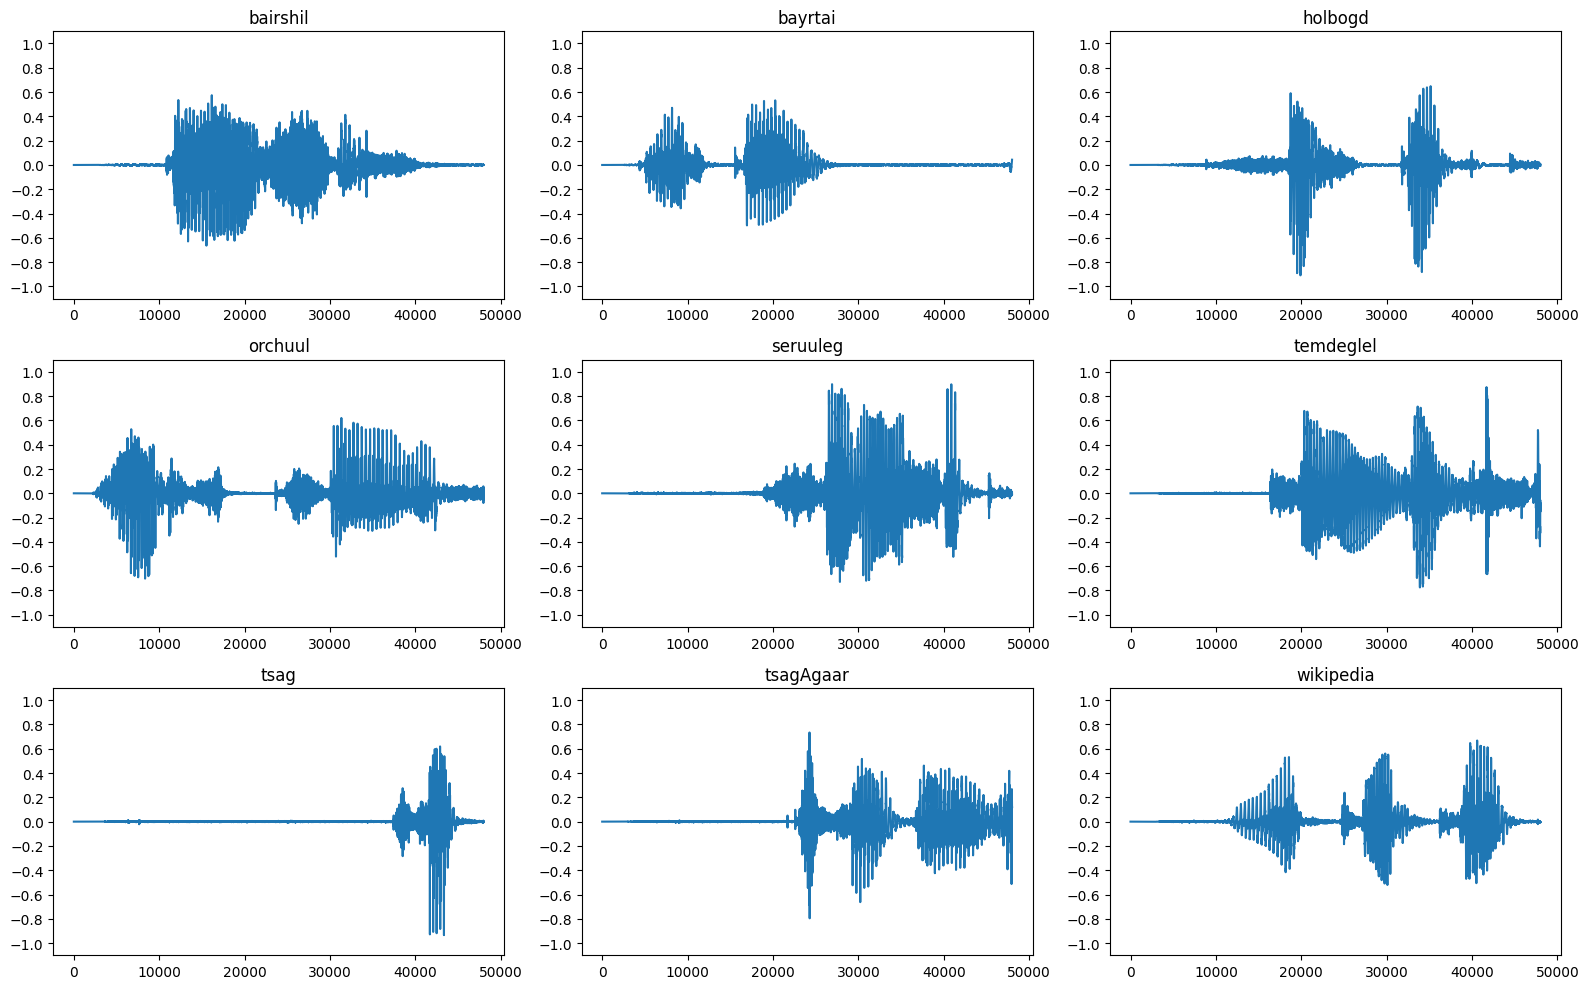

In [ ]:
unique_labels, unique_indices = np.unique(example_labels, return_index=True)

plt.figure(figsize=(16, 10))
rows, cols = 3, 3

for i in range(min(9, len(unique_labels))):
    plt.subplot(rows, cols, i + 1)
    audio_signal = example_audio[unique_indices[i]]
    label_name = label_names[unique_labels[i]]
    plt.plot(audio_signal)
    plt.title(label_name)
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

plt.tight_layout()
plt.show()

In [ ]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [15]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=48000))

Label: tsagAgaar
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Label: temdeglel
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Label: tsagAgaar
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

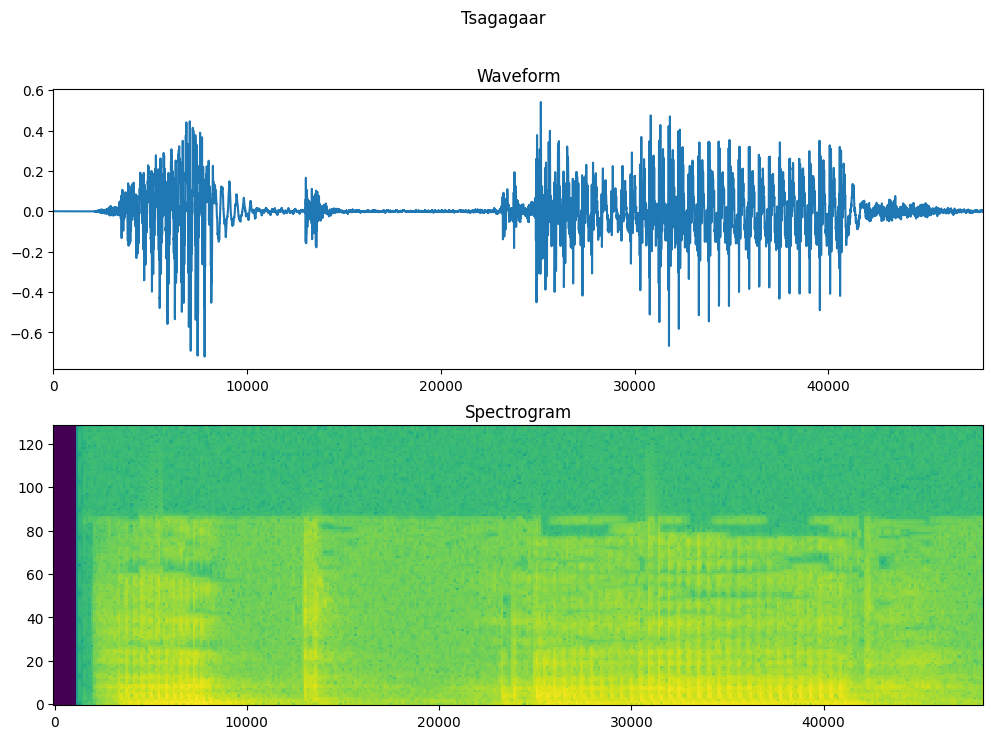

In [17]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 48000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [18]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [20]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

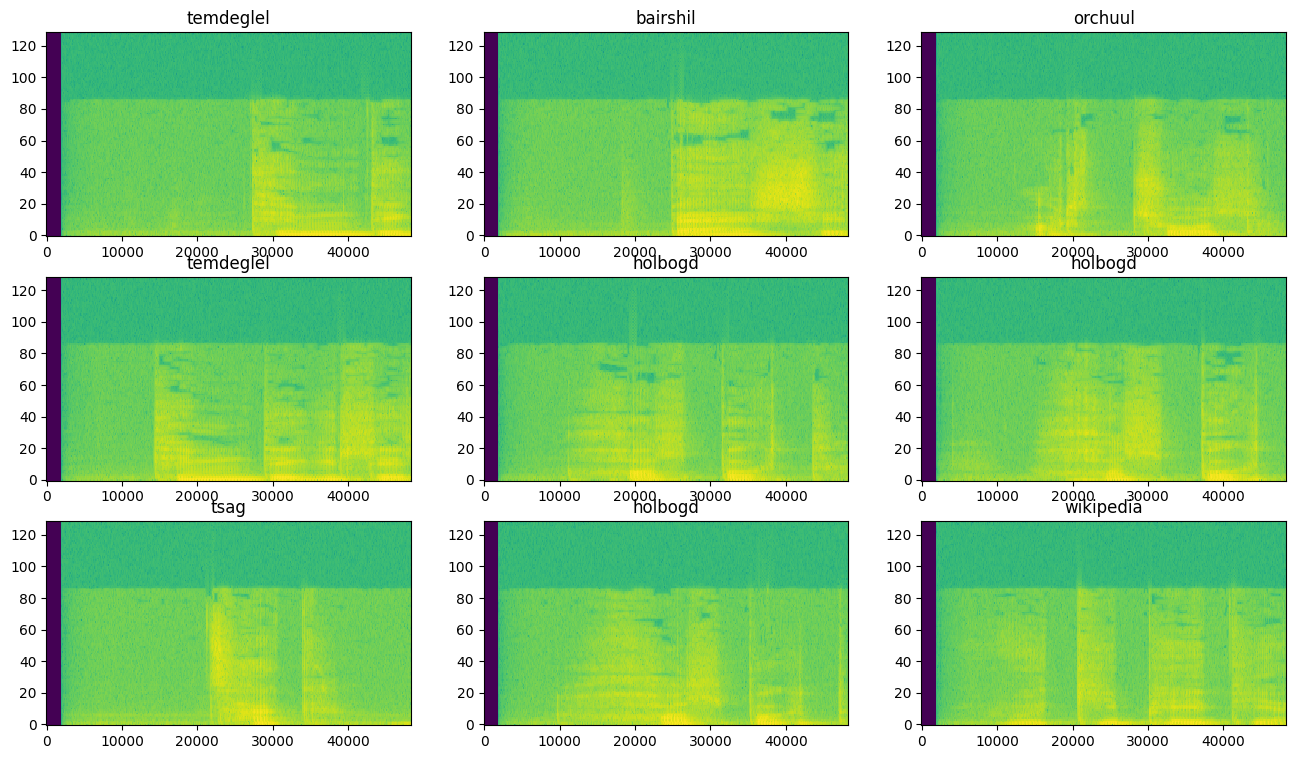

In [21]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [22]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (374, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,740 (6.20 MB)

 Trainable params: 1,625,737 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [25]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.6707 - loss: 0.9777 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9951 - loss: 0.0240 - val_accuracy: 1.0000 - val_loss: 4.0385e-04
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9964 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 7.5113e-05
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9957 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 6.4292e-05
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9979 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 1.1480e-05
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9980 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 6.5368e-05
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9958 - loss: 0.0152 - val_accuracy: 1.0000 - val_loss: 9.0259e-06
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9975 -

Let's plot the training and validation loss curves to check how your model has improved during training:

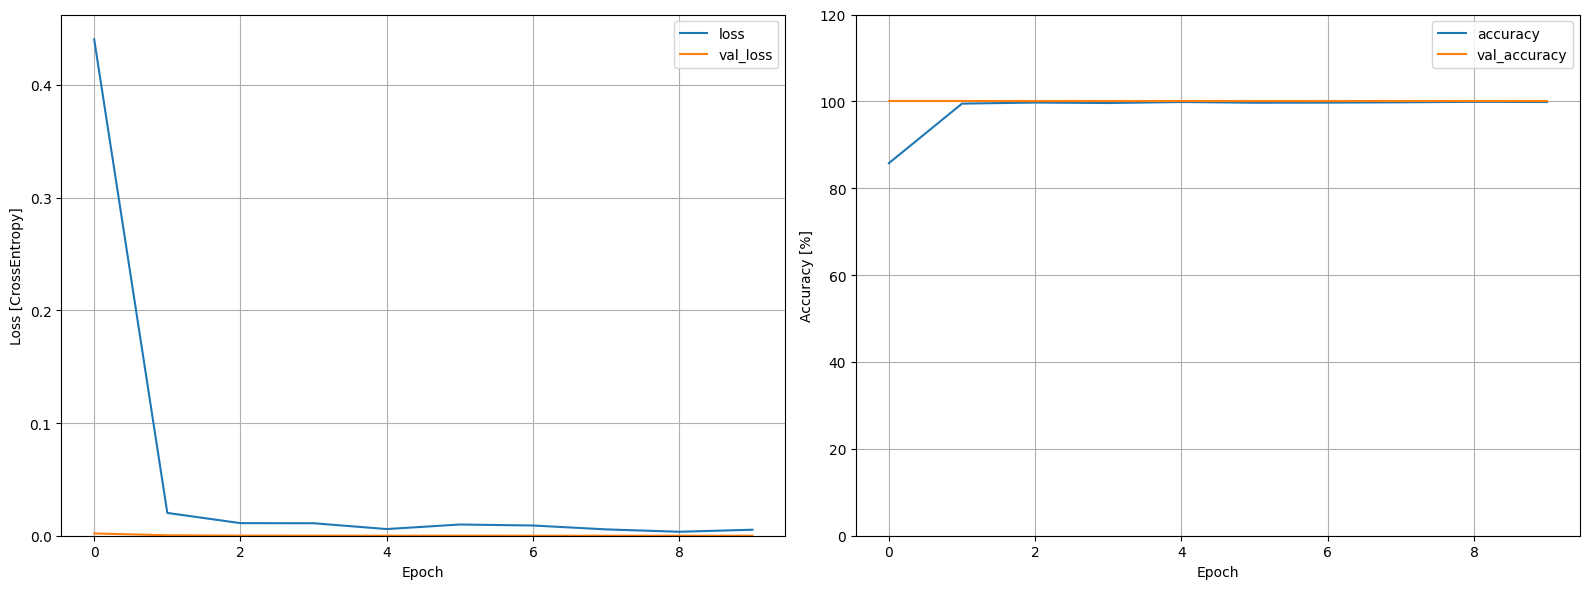

In [26]:
metrics = history.history
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])

plt.ylim([0, 120]) 
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.grid(True)

plt.tight_layout()
plt.show()


In [27]:
model.evaluate(test_spectrogram_ds, return_dict=True)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 1.0000 - loss: 1.8392e-06


{'accuracy': 1.0, 'loss': 2.1261200799926883e-06}

In [28]:
y_pred = model.predict(test_spectrogram_ds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [29]:
y_pred = tf.argmax(y_pred, axis=1)

In [30]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

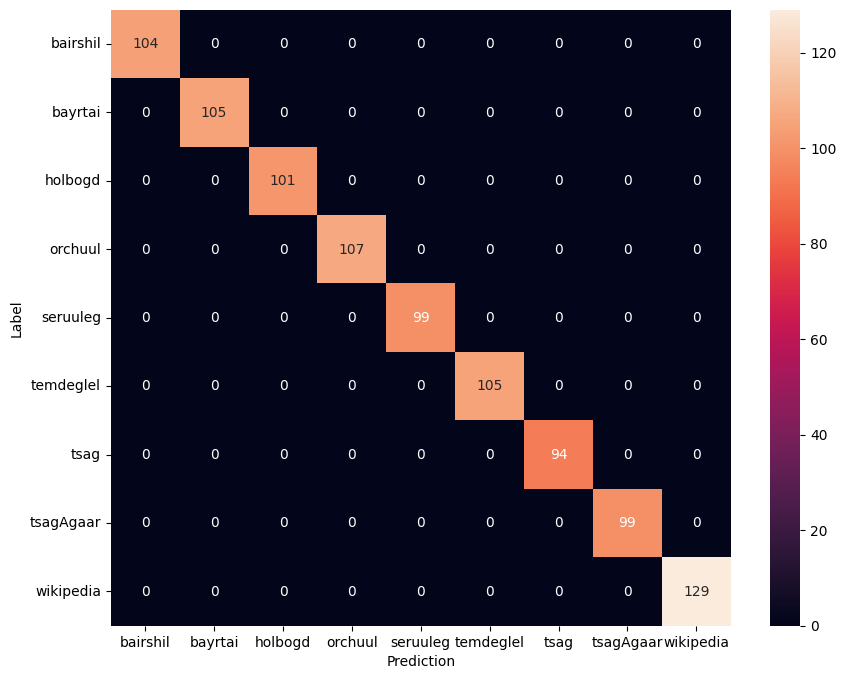

In [32]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
import tensorflow as tf
from IPython.display import Audio, display

x = data_dir / 'tsag/tsag-1930.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1)
x = tf.squeeze(x, axis=-1)
waveform = x

print("Sample rate:", sample_rate.numpy())
print("Waveform shape:", waveform.shape)

display(Audio(waveform.numpy(), rate=sample_rate.numpy()))


Sample rate: 48000
Waveform shape: (64512,)


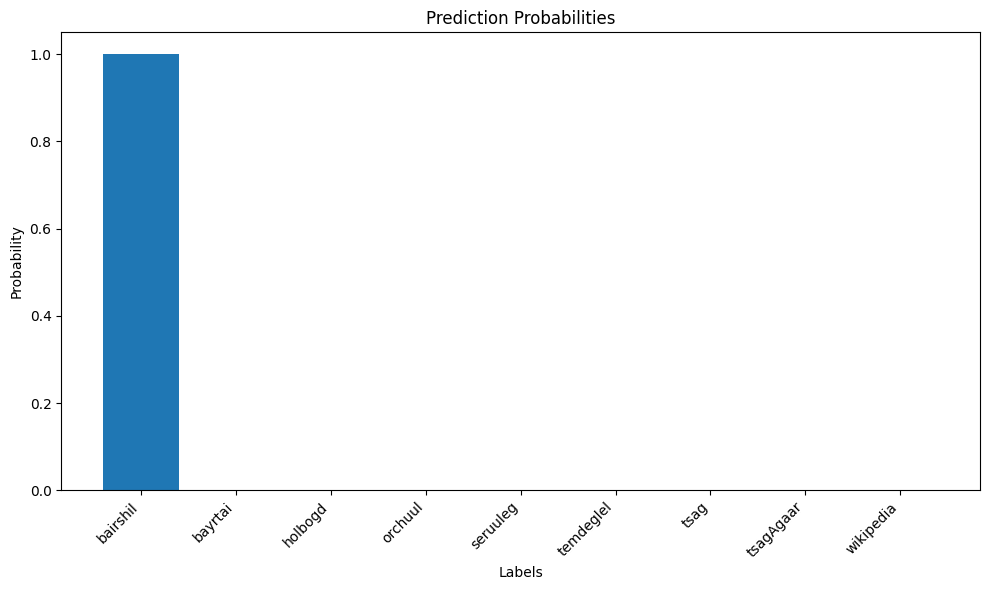

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Audio

x = data_dir / 'bairshil/bairshil-1930.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=48000)
x = tf.squeeze(x, axis=-1)
waveform = x

display(Audio(waveform.numpy(), rate=48000))

x = get_spectrogram(x)
x = x[tf.newaxis, ...]
prediction = model(x)

x_labels = ['bairshil', 'bayrtai', 'holbogd', 'orchuul', 'seruuleg',
            'temdeglel', 'tsag', 'tsagAgaar', 'wikipedia']
plt.figure(figsize=(10, 6))
plt.bar(x_labels, tf.nn.softmax(prediction[0]))

plt.xticks(rotation=45, ha='right')
plt.title('Prediction Probabilities')
plt.ylabel('Probability')
plt.xlabel('Labels')

plt.tight_layout()
plt.show()


In [35]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 48000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=48000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [ ]:
export = ExportModel(model)
model.save("saved_model.keras")


In [ ]:
from tensorflow.keras.models import load_model

imported_model = load_model("saved_model.keras")

spectrogram = get_spectrogram(waveform)
spectrogram = tf.image.resize(spectrogram, [124, 129])

spectrogram = spectrogram[tf.newaxis, ...]
predictions = imported_model.predict(spectrogram)
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[[ 31.100359     3.5905337   -3.8209484   -0.10600027  -2.271505
   -1.5247978   -1.1921966   -8.386481   -14.999555  ]]
